<a href="https://colab.research.google.com/github/lucas-fpaiva/tcc_pes/blob/main/preprocessing/final_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entendendo o problema de predição de saude da aeronave

Objetivos:

* Separar duas aeronaves para o teste final 
* Selecionar duas das séries para analisar dentro das aeronaves de treino
* Visualizar e realizar o preprocessamento dos dados
* Aplicar um modelo de predição usando uma para treinar e outra para testar

In [60]:
print("Estou rodando no Colab (S/N)?")
ambiente = input()
ambiente=ambiente.upper()

if ambiente == "S":
  from google.colab import drive
  import os

  drive.mount('/content/drive',force_remount=True)
  os.chdir('/content/drive/Shareddrives/TCC_PES/codigos')

Estou rodando no Colab (S/N)?
s
Mounted at /content/drive


## Tratamento e organização inicial dos dados

In [61]:
#bibliotecas de manipulação de dados
import pandas as pd
import numpy as np

#visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as py
import matplotlib.gridspec as gridspec
from ast import literal_eval

#pré processamento
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#modelos recorrentes Keras
from tensorflow.keras.layers import SimpleRNN as RNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping

#bibliotecas necessárias para gridsearch
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#modelo sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

#métricas de avaliação dos modelos.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error

#biblioteca Tensorflow
from tensorflow.keras.utils import set_random_seed 

### Tratamento inicial dos dados
* Mediana dos dias 
* Unificação dos datasets 
* Separação treino e teste final

In [62]:
#importando direto do github
data_feat = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/caracteristica.csv')
data_health = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/saude.csv')

# Unificação dos datasets #####

#calculando a mediana dos dados
data_health = data_health.groupby(by=['COD_FALH','COD_AENV','DT_PROC']).median().reset_index()
data_feat = data_feat.groupby(by=['COD_FALH','COD_AENV','COD_EVNT']).median().reset_index()

#Unificando os datasets 
data_health['id']=data_health.index
data_health.head()
data_all = pd.merge(data_feat, data_health, on=['COD_EVNT','COD_FALH','COD_AENV']).sort_values('DT_PROC')


### Separação treino teste
np.random.seed(123)
np.random.randint(0,2,10)
test = np.random.choice(np.unique(data_health.COD_AENV),2)

# Treino 
data  = data_all[data_all.COD_AENV != test[0]][data_all.COD_AENV != test[1]]
print("Aviões usados para teste: ", test)


## Teste final
data_test = data_all[(data_all.COD_AENV == test[0]) | (data_all.COD_AENV == test[1])]
print("Aviões usados para validação k-fold: ", np.unique(data_health.COD_AENV))

Aviões usados para teste:  [9834 9747]
Aviões usados para validação k-fold:  [1011 9486 9526 9636 9664 9678 9747 9770 9793 9834]


/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:1218: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Separação das amostras

In [63]:
#aplica filtro de média móvel

def serie_breaks (desgaste,fail):
  if fail ==35:
    dist =20
  else:
    dist =3
  quebras = []
  for i in range(0,len(desgaste)-1):
    if abs(desgaste[i]-desgaste[i+1])>dist:
      quebras.append(i)
  quebras = np.array(quebras)

  return quebras


#Transforma o banco de dados em instâncias/amostras de acordo com o janela de tempo utilizada
def get_samples (data, fail, look_back):
  samples=[]
  samples_day=[]
  n = look_back+10 #Tamanho (Dias) necessário da amostra

  for aircraft in np.unique(data.COD_AENV):
      air_data = data[(data.COD_AENV==aircraft)  & (data.COD_FALH==fail)] #filtrando por aeronave e fail
      degradation = air_data.VLR_DESG.values
      day = air_data.DT_PROC.values
      discontinuities = serie_breaks(degradation,fail) #identificando as descontinuidades
      discontinuities=np.append(discontinuities, len(degradation)-1) #insere o fim do trecho
      init=0
      for i in range(0,len(discontinuities)): 
        interval_break=degradation[init:discontinuities[i]+1] #intervalo entre duas quebras
        interval_days = day[init:discontinuities[i]+1] #dias correspondentes ao intervalo 
        init=discontinuities[i]+1
        if len(interval_break)>=look_back+10: #verifica se os intervalos possuem a quantidade minima de valores
            for i in range(0,len(interval_break)-n+1): #separa os intervalos em amostras
              sample = interval_break[i:i+n].tolist() #uma amostra com n valores
              sample_day = interval_days[i:i+n].tolist() #dias correspondentes à amostra
              sample_day.append(aircraft)
              sample.append(aircraft)
              samples.append(sample)
              samples_day.append(sample_day)
      
  samples = np.array(samples)
  samples_day = np.array(samples_day)
  return  samples, samples_day 


#Normalização das amostras
def normalize_samples(samples, norm_method):
  if norm_method=="MM(-1,1)":
    scaler = MinMaxScaler(feature_range=(-1, 1))
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  elif norm_method=="MM(0,1)":
    scaler = MinMaxScaler(feature_range=(0, 1))
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  elif norm_method=="Zscore":
    scaler = StandardScaler()
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  else:
    return samples


#Separa as amostras em em X,Y e treino, teste
def split_train_test (samples, air_test, look_back, norm_method=False, reshape=True): 
  data_train = samples[samples[:, look_back+10] != air_test][:, 0:look_back+10] #dados de treino
  #seperação de x e y
  x_train = data_train[:,0:look_back]
  y_train = data_train[:,look_back+9]

  if air_test==False:
    if norm_method != False:
      x_train, x_scaler = normalize_samples(x_train, norm_method)
      y_train, y_scaler = normalize_samples(y_train.reshape(-1, 1), norm_method)

      if reshape==True:
        x_train = np.reshape(x_train, (x_train.shape[0],1, x_train[0].shape[0])) 
        y_train = np.reshape(y_train, (y_train.shape[0],1, 1))
        return x_train, y_train, y_scaler, x_scaler

      else:
        return x_train, y_train, y_scaler, x_scaler
  
    return x_train, y_train

  data_test = samples[samples[:, look_back+10] == air_test][:, 0:look_back+10] #dados de teste
  #seperação de x e y
  x_test = data_test[:,0:look_back]
  y_test = data_test[:,look_back+9]

  #normalização de x e y
  x_train, x_scaler = normalize_samples(x_train, norm_method)
  x_test = x_scaler.transform(x_test)
  y_train, y_scaler = normalize_samples(y_train.reshape(-1, 1), norm_method)
  y_test = y_scaler.transform(y_test.reshape(-1, 1))

  #reshape para treinar os modelos recorrentes
  if reshape==True:
      x_train = np.reshape(x_train, (x_train.shape[0],1, x_train[0].shape[0])) 
      y_train = np.reshape(y_train, (y_train.shape[0],1, 1))
      x_test  = np.reshape(x_test , (x_test.shape[0], 1, x_test[0].shape[0]))
      y_test = np.reshape(y_test, (y_test.shape[0], 1,1))

  #retorna os scalers para reverter a normalização
  return x_train, y_train, x_test, y_test, y_scaler, x_scaler 


##GridSearch

### Funções implementadas

In [64]:
#Retorna todas as métricas calculadas
def metrics(y_true,y_pred):
  mse  = mean_squared_error(y_true, y_pred) 
  rmse = mean_squared_error(y_true, y_pred, squared = False)
  max_e = max_error(y_true, y_pred) 
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  return([rmse, mse, max_e, mae, r2])

#Seleciona o modelo
def shallow_model (name, n_recurr, n_dense, dropout, l2, look_back, forget_gate=True):
  model = Sequential()
  if name == "LSTM":
      model.add(LSTM(n_recurr, input_shape=(1, look_back)))
  elif name=="GRU":
      model.add(GRU(n_recurr, input_shape=(1, look_back)))
  elif name == "RNN":
      model.add(RNN(n_recurr, input_shape=(1, look_back)))
  else:
      print("Model not found")

  if n_dense>0:
    if l2==True:
      model.add(Dense(n_dense, kernel_regularizer='l2'))
    else:
      model.add(Dense(n_dense))

  model.add(Dropout(dropout))

  if l2==True:
    model.add(Dense(1, kernel_regularizer='l2'))
  else:
    model.add(Dense(1))
  
  return model




#Seleciona o modelo
def deep_model (name, n_recurr, n_dense, dropout, l2, look_back, forget_gate=True):
  model = Sequential()
  if name == "LSTM":
      model.add(LSTM(n_recurr[0], input_shape=(1, look_back), return_sequences = True))
      model.add(LSTM(n_recurr[1], return_sequences = True))
      model.add(LSTM(n_recurr[2]))
  elif name=="GRU":
      model.add(GRU(n_recurr[0], input_shape=(1, look_back), return_sequences = True))
      model.add(GRU(n_recurr[1], return_sequences = True))
      model.add(GRU(n_recurr[2]))
  elif name == "RNN":
      model.add(RNN(n_recurr[0], input_shape=(1, look_back), return_sequences = True))
      model.add(RNN(n_recurr[1], return_sequences = True))
      model.add(RNN(n_recurr[2]))
  else:
      print("Model not found")

  if n_dense>0:
    if l2==True:
      model.add(Dense(n_dense, kernel_regularizer='l2'))
    else:
      model.add(Dense(n_dense))

  model.add(Dropout(dropout))

  if l2==True:
    model.add(Dense(1, kernel_regularizer='l2'))
  else:
    model.add(Dense(1))
  
  return model

#
def grid_search_recurrent (data, fail, windows98, model_name, n_recurr, n_dense, dropout, l2, norm_methods, approach):

  data_results = pd.DataFrame([],columns=['RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo','MOD_FALH',
                                          "Janela",'AENV','Normalização','N_Parâmetros', 'Parâmetros'])

  for look_back in windows98:
    amostras, _ = get_samples (data, fail, look_back)
    results = []
    for norm_method in norm_methods:
      for aero_test in np.unique(data.COD_AENV):
        x_train, y_train, x_test, y_test, scaler, _ = split_train_test (amostras, aero_test, look_back, norm_method, reshape = True)
        for name in model_name:
          for n_r in n_recurr:
            for n_d in n_dense:
              for drop in dropout:
                for l in l2:
                  if approach=="shallow":
                    model = shallow_model(name, n_r, n_d, drop, l, look_back)
                  elif approach=="deep":
                    model = deep_model(name, n_r, n_d, drop, l, look_back)
                  else:
                    print("Approach not found!")
                  
                  early_stopping = EarlyStopping(patience=5)
                  model.compile(loss='mean_squared_error', optimizer='adam')
                  model.fit(x_train, y_train, epochs=400, batch_size=170, validation_split=0.2, callbacks=[early_stopping], verbose=0)
                  
                  #revertendo a normalização
                  y_test_rev = scaler.inverse_transform(y_test[:,0].reshape(-1,1))
                  y_pred_rev = scaler.inverse_transform(model.predict(x_test, verbose=0)[:,0].reshape(-1,1))
                  
                  #adiciona os resultados em uma lista
                  result = metrics(y_test_rev,y_pred_rev)
                  result.append(name)
                  result.append(fail)
                  result.append(look_back)
                  result.append(int(aero_test))
                  result.append(norm_method)
                  result.append(model.count_params())
                  parameters = {'Recurrent': n_r, 'Dense': n_d, 'Dropout': drop, 'L2': l}
                  result.append(parameters)
                  #salvando os resultados  
                  results.append(result)
                  # print(['RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo','MOD_FALH',"Janela",'AENV','Normalização','N_Parâmetros', 'Parâmetros'])
                  # print(result)
                  # print()
    data_results = pd.concat([data_results, pd.DataFrame(results,
                    columns= ['RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo','MOD_FALH',"Janela",'AENV','Normalização','N_Parâmetros', 'Parâmetros'])])
    filename = 'resultados/recurrent_'+approach+'_lk'+str(look_back)+'_f'+str(fail)+'.csv'
    print(filename)
    data_results.to_csv(filename) #exporta os resultados em CSV para cada tamanho de janela

In [65]:
#
def kfold_top(samples, look_back):
  data_samples = pd.DataFrame(samples)
  folds = []
  for air_test in np.unique(data.COD_AENV):
    folds.append([(data_samples[data_samples[look_back+10] !=air_test].index.values), 
                  (data_samples[data_samples[look_back+10] == air_test].index.values)])
  return folds

#
def classical_model (name, parameters=False):
  if name == "MLP":
    if parameters == False:
      model = MLPRegressor()
    else:
      model = MLPRegressor(**parameters)

  elif name=="LR":
    if parameters == False:
      model = LinearRegression()#**parameters)
    else:
      model = LinearRegression(**parameters)

  elif name == "SVR":
    if parameters == False:
      model = SVR()
    else:
      model = SVR(**parameters)
  else:
      print("Model not found")

  return model

#Retorna um dataframe com os melhores modelos e suas respectivas métricas de acordo com o gridsearch
def grid_results(gs, name_model, fail, look_back, norm_method):
  data_results = pd.DataFrame(gs.cv_results_)
  data_results = data_results[data_results['rank_test_neg_root_mean_squared_error']==1]
  results_list = []
  metrics_gs=['_test_neg_root_mean_squared_error', '_test_neg_mean_squared_error', '_test_max_error', '_test_neg_mean_absolute_error', '_test_r2']
  for n in range(0,8):
    results_fold = []
    for metric in metrics_gs:
      metric = "split"+str(n)+metric
      results_fold.append(data_results[metric].values[0]*-1)
    
    results_fold.append(name_model)
    results_fold.append(fail)
    results_fold.append(look_back)
    results_fold.append(n)
    results_fold.append(norm_method)
    results_fold.append(None)
    results_fold.append(gs.best_params_)
    results_list.append(results_fold)

  dataframe_results = pd.DataFrame(results_list,columns=['RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo','MOD_FALH',"Janela",'AENV','Normalização','N_Parâmetros', 'Parâmetros']) 
  dataframe_results["R2"] = dataframe_results["R2"].apply(lambda x: x*-1)
  return(dataframe_results)

#
def grid_search_classical (data, fail, windows98, grid, norm_methods):
  data_results = pd.DataFrame([],columns=['RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo','MOD_FALH',
                                          "Janela",'AENV','Normalização','N_Parâmetros', 'Parâmetros'])

  for look_back in windows98:
    samples, _ = get_samples (data, fail, look_back)
    for norm_method in norm_methods:
      for name in list(grid.keys()):
        x_train, y_train = split_train_test(samples, False, look_back, reshape=False)
        model = classical_model(name)

        if norm_method=="MM(-1,1)":
          scaler = MinMaxScaler(feature_range=(-1, 1))
          pipe=make_pipeline(scaler, model)
        elif norm_method=="MM(0,1)":
          scaler = MinMaxScaler(feature_range=(0, 1))
          pipe=make_pipeline(scaler, model)
        elif norm_method=="Zscore":
          scaler = StandardScaler()
          pipe=make_pipeline(scaler, model)

        gs=GridSearchCV(pipe, param_grid=grid[name], n_jobs=-1, cv=kfold_top(samples,look_back), verbose=0, refit='neg_mean_squared_error',
                        scoring=['neg_root_mean_squared_error','neg_mean_squared_error', 'max_error', 'neg_mean_absolute_error', 'r2'])
        #fitting gs to training data
        gs.fit(x_train, y_train)
        results = grid_results(gs, name, fail, look_back, norm_method)
        data_results = pd.concat([data_results, results])
    filename = 'resultados/classical_lk'+str(look_back)+'_f'+str(fail)+'.csv'
    print(filename)
    data_results.to_csv(filename) #exporta os resultados em CSV para cada tamanho de janela

In [ ]:
#parâmetros a serem passado para o GridSearch
grid={'MLP':{
        'mlpregressor__random_state': [0],
        'mlpregressor__activation': ['tanh','relu'],
        'mlpregressor__solver' : ["adam"],
        'mlpregressor__hidden_layer_sizes': [5, 10, 25, 30, (2,2), (108,108,54), (162,162,108)],
        'mlpregressor__learning_rate_init': [0.001, 0.01 , 0.2],
        'mlpregressor__batch_size': [30],
        'mlpregressor__early_stopping': [True],
        'mlpregressor__n_iter_no_change': [5],
        'mlpregressor__validation_fraction': [0.2],
        'mlpregressor__max_iter': [500]},
      
      'SVR':{
        'svr__kernel': ['rbf', 'linear'], #default: rbf 
        # 'svr__gamma': [0.1, 10, 1000, 100000],
        'svr__epsilon': [0.001, 0.1],
        'svr__C': [0.4, 4, 40, 400, 4000]}, #[0.001, 0.01, 0.1, 1, 10]
      
      'LR':{
        'linearregression__n_jobs': [-1]}}

In [ ]:
grid_test={'MLP':{
        'mlpregressor__random_state': [0],
        'mlpregressor__hidden_layer_sizes': [1,2],
        'mlpregressor__batch_size': [200],
        'mlpregressor__early_stopping': [True],
        'mlpregressor__n_iter_no_change': [5],
        'mlpregressor__validation_fraction': [0.2],
        'mlpregressor__max_iter': [500]},
      # 'SVR':{
      #   'svr__kernel': ['rbf', 'linear'], #default: rbf 
      #   'svr__gamma': [0.1, 10],
      #   'svr__C': [0.4, 4]}, #[0.001, 0.01, 0.1, 1, 10]
      'LR':{
        'linearregression__n_jobs': [-1]}}

## Treinamento dos modelos k-fold

### Treinamento e predição dos modelos clássicos

In [ ]:
norm_methods = ["MM(-1,1)", "MM(0,1)", "Zscore"]
windows98 = [10,20,30]
fail=23

grid_search_classical(data, fail, windows98, grid, norm_methods)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



resultados/classical_lk10_f1.csv


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



### Treinamento e predição do modelo shallow

In [ ]:
norm_methods = ["MM(-1,1)", "MM(0,1)",  "Zscore"]# ,
windows98 = [30]# [10,20,30]
fail = 23
model_name = ['RNN', 'GRU', 'LSTM']
n_recurr = [32, 256]#[14,16,21,32,64,128,256]
n_dense = [0,56]
dropout =[0, 0.5]#[0, 0.5, 0.7]
l2 =[True, False]
approach="shallow"
#bjkb
grid_search_recurrent (data, fail, windows98, model_name, n_recurr, n_dense, dropout, l2, norm_methods, approach)


KeyboardInterrupt: ignored

In [ ]:
#Selecionando os melhores modelos para cada faila
data_results=pd.read_csv('resultados/recurrent_shallow_lk30_f1.csv', index_col=0)
print(data_results.shape)
data_results_new = data_results.groupby(['Modelo','Parâmetros', "Janela","Normalização"]).mean().reset_index()
print(data_results_new.shape)

data_results_new = data_results_new.groupby(['Modelo']).apply(lambda x: x[x['RMSE'] == x['RMSE'].min()]).reset_index(drop=True)
print(data_results_new.shape)

data_results_new.head()

(48, 12)
(6, 12)
(3, 12)


,Modelo,Parâmetros,Janela,Normalização,RMSE,MSE,MaxE,MAE,R2,MOD_FALH,AENV,N_Parâmetros
0,GRU,"{'Recurrent': 1, 'Dense': 0, 'Dropout': 0, 'L2...",30,"MM(-1,1)",6.559879,49.611389,24.878313,4.576101,0.847506,1.0,8570.5,101.0
1,LSTM,"{'Recurrent': 1, 'Dense': 0, 'Dropout': 0, 'L2...",30,"MM(-1,1)",7.060451,63.550619,23.839562,4.892863,0.840016,1.0,8570.5,130.0
2,RNN,"{'Recurrent': 1, 'Dense': 0, 'Dropout': 0, 'L2...",30,"MM(-1,1)",5.881121,36.890541,24.065176,4.154460,0.872092,1.0,8570.5,34.0


###Treinamento e predição do modelo deep

In [ ]:
norm_methods = ["MM(-1,1)", "MM(0,1)", "Zscore"]
windows98 = [30]#[10, 20, 30]#[5,10,15,20,25,30]
fail = 23
model_name = ['RNN', 'GRU', 'LSTM']
n_recurr = [[14, 21, 14],  [21, 28, 21]]
n_dense = [0,56]
dropout = [0, 0.5]#[0, 0.5, 0.7]
l2 = [True, False]
approach="deep"
#  
grid_search_recurrent (data, fail, windows98, model_name, n_recurr, n_dense, dropout, l2, norm_methods, approach)

KeyboardInterrupt: ignored

In [ ]:
#Selecionando os melhores modelos para cada fail
data_results=pd.read_csv('resultados/recurrent_deep_lk10_f1.csv', index_col=0)
print(data_results.shape)
data_results_new = data_results.groupby(['Modelo','Parâmetros', "Janela","Normalização"]).mean().reset_index()
print(data_results_new.shape)

data_results_new = data_results_new.groupby(['Modelo']).apply(lambda x: x[x['RMSE'] == x['RMSE'].min()]).reset_index(drop=True)
print(data_results_new.shape)

data_results_new.head()

(72, 12)
(9, 12)
(3, 12)


,Modelo,Parâmetros,Janela,Normalização,RMSE,MSE,MaxE,MAE,R2,MOD_FALH,AENV,N_Parâmetros
0,GRU,"{'Recurrent': [1, 1, 1], 'Dense': 0, 'Dropout'...",10,"MM(-1,1)",5.831858,39.090050,22.933324,3.979245,0.865773,1.0,8570.5,65.0
1,LSTM,"{'Recurrent': [1, 1, 1], 'Dense': 0, 'Dropout'...",10,"MM(-1,1)",6.276456,45.269136,24.538913,4.352617,0.835047,1.0,8570.5,74.0
2,RNN,"{'Recurrent': [1, 1, 1], 'Dense': 0, 'Dropout'...",10,"MM(-1,1)",5.692653,34.835639,23.562905,4.039506,0.871379,1.0,8570.5,20.0


#Visualização dos resultados

In [139]:
fail = int (input())

23


In [85]:
#Paleta de cores do BoxPlot
colors1 = [    
          (15/255,114/255,255/255,1), # blue 
          (224/255,0/255,193/255,.88), #pink
          (1.0, 0.807843137254902, 0.0392156862745098, 1), #orange
          (0.95, 0, 0, 1), #red
          (0, 0.6666666666666666, 0.6274509803921569, 1), #green
          
          (0, 0.9764705882352941, 0, 0.5), #       
          (10/255,10/255, 130/255, 1), #(0.4, 0.0, 0.6, 1), # green
          (0.6, 0/255, 0.4, 0.8)#
        ]

In [95]:
#Retorna todas as métricas calculadas para o teste
def metrics_test(y_true,y_pred, indice):
  mse_1 = round(mean_squared_error(y_true[0:indice], y_pred[0:indice]), 3)
  mse_2 = round(mean_squared_error(y_true[indice:], y_pred[indice:]), 3)
  # mse = np.mean([mse_1, mse_2])
  # std_mse = np.std([mse_1, mse_2])
  mse = "["+str(mse_1 if mse_1<mse_2 else mse_2)+", "+str(mse_1 if mse_1>=mse_2 else mse_2)+"]"
  # print(mean_squared_error(y_true, y_pred))
  # print(mse)

  rmse_1 = round(mean_squared_error(y_true[0:indice], y_pred[0:indice], squared = False), 3)
  rmse_2 = round(mean_squared_error(y_true[indice:], y_pred[indice:], squared = False), 3)
  rmse_mean = round(np.mean([rmse_1, rmse_2]), 3)
  # std_rmse = np.std([rmse_1, rmse_2])
  rmse = "["+str(rmse_1 if rmse_1<rmse_2 else rmse_2)+", "+str(rmse_1 if rmse_1>=rmse_2 else rmse_2)+"]"
  # print(str(rmse_1)+" | "+str(rmse_2))
  # print(mean_squared_error(y_true, y_pred, squared = False))
  # print(rmse)
  
  max_e_1 = round(max_error(y_true[0:indice], y_pred[0:indice]), 3)
  max_e_2 = round(max_error(y_true[indice:], y_pred[indice:]), 3)
  # max_e = np.mean([max_e_1, max_e_2])
  # std_max_e = np.std([max_e_1, max_e_2])
  max_e = "["+str(max_e_1 if max_e_1<max_e_2 else max_e_2)+", "+str(max_e_1 if max_e_1>=max_e_2 else max_e_2)+"]"
  # print(max_error(y_true, y_pred))
  # print(max_e)
  

  mae_1 = round(mean_absolute_error(y_true[0:indice], y_pred[0:indice]), 3)
  mae_2 = round(mean_absolute_error(y_true[indice:], y_pred[indice:]), 3)
  # mae = np.mean([mae_1, mae_2])
  # std_mae = np.std([mae_1, mae_2])
  mae = "["+str(mae_1 if mae_1<mae_2 else mae_2)+", "+str(mae_1 if mae_1>=mae_2 else mae_2)+"]"
  # print(mean_absolute_error(y_true, y_pred))
  # print(mae)

  r2_1 = round(r2_score(y_true[0:indice], y_pred[0:indice]), 3)
  r2_2 = round(r2_score(y_true[indice:], y_pred[indice:]), 3)
  # r2 = np.mean([r2_1, r2_2])
  # std_r2 = np.std([r2_1, r2_2])
  r2 = "["+str(r2_1 if r2_1<r2_2 else r2_2)+", "+str(r2_1 if r2_1>=r2_2 else r2_2)+"]"
  # print(r2_score(y_true, y_pred))
  # print(r2)

  return([rmse_mean, rmse, mse, max_e, mae, r2])

#Retorna o índice das séries de teste
def index_test(samples_test, look_back_best):
  np.diff(samples_test[:,look_back_best+10])

  count = 0
  for i in np.diff(samples_test[:,look_back_best+10]):
    # print (i)
    if i !=0:
      indice = count
    count = count+1

  return indice

#Importa e concatena os resultados
def concat_results(model_type, fail):
  if model_type == 'deep' or model_type=='shallow':
    model_type = "recurrent_"+model_type

  #importa os .csv
  lk10 = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/results/'+model_type+'_lk10_f'+str(fail)+'.csv', index_col = 0)
  lk20 = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/results/'+model_type+'_lk20_f'+str(fail)+'.csv', index_col = 0)
  lk30 = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/results/'+model_type+'_lk30_f'+str(fail)+'.csv', index_col = 0)

  #concatena os .csv
  results = pd.concat([lk10, lk20, lk30])

  if model_type == "classical":
    results_top = results.groupby(['Modelo','Janela']).apply(lambda x: x[x['RMSE'] == x['RMSE'].min()]).reset_index(drop=True)
    return results, results_top
  
  else:
    results_top = results.groupby(['Modelo','Normalização', 'Parâmetros', "Janela"]).mean().reset_index()
    results_top = results_top.groupby(['Modelo','Janela']).apply(lambda x: x[x['RMSE'] == x['RMSE'].min()]).reset_index(drop=True)
    return results, results_top

# Retorna os os melhores modelos por janela para cada tipo de modelo ("deep",...)
def get_best_models (model_type, fail):
  results, results_top = concat_results(model_type, fail)
  if model_type == 'deep' or model_type=='shallow':
    models = ["LSTM", "GRU","RNN"]
  else:
    models = ["MLP", "SVR", "LR"]

  best_models = pd.DataFrame()
  
  for model in models:
    for lk in [10,20,30]:
      top = results_top.loc[results_top.Modelo == model]
      top = top.loc[top.Janela == lk]
      norm = top["Normalização"].values[0]

      # print(top["Normalização"].values[0])

      param =  top["Parâmetros"].values[0]
      
      best_model = results[results.Modelo == model]
      best_model = best_model[best_model.Janela == lk]
      best_model = best_model[best_model.Normalização == norm] 
      best_model = best_model[best_model.Parâmetros == param]

      best_models = pd.concat([best_models,best_model]) #Melhor modelo de cada janela para todas aeronaves

  best_models.groupby(['Modelo','Normalização', 'Parâmetros', "Janela"]).std().reset_index().head()
  return best_models


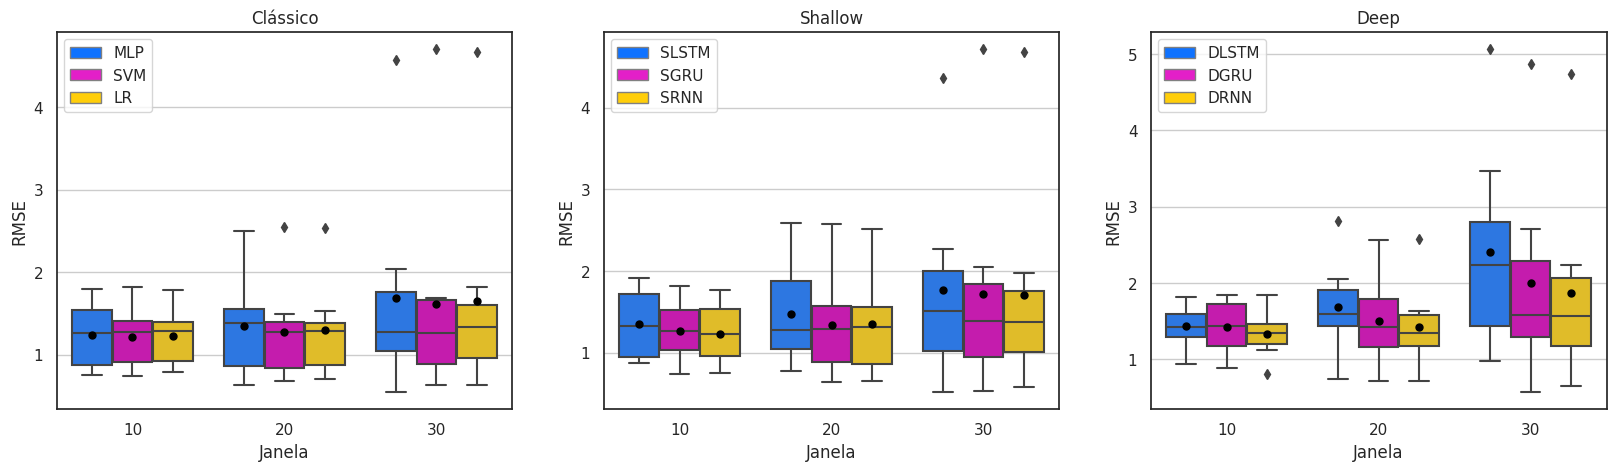

In [69]:
#Importação e BoxPlot dos melhores modelos
import matplotlib.patches as mpatches
sns.set_theme(style="white", palette=None)
fig = plt.figure(figsize = (20,5),dpi=100)
axes = gridspec.GridSpec(nrows=1, ncols=3, figure=fig, wspace=0.2, hspace=0.3)

# im = ['a','b','c']
count=0

for model_type in ["classical", "shallow", "deep"]:
  best_models = get_best_models(model_type, fail)
  best_models['Combinação'] = best_models ["Normalização"] +'+'+ best_models ["Modelo"]

  ax = fig.add_subplot(axes[count])
  ax.grid()
  
  sns.boxplot(data = best_models, y='RMSE',x='Janela',hue='Modelo', palette = colors1,
              showmeans=True,meanprops={"marker":".", "markerfacecolor":"black", 
                        "markeredgecolor":"black", "markersize":"10"})
  # ax.text(-0.05, -0.1, im[count], size=20, weight='bold', transform=ax.transAxes)
  if model_type == "shallow":
    ax.set_title("Shallow")
    labels = ['SLSTM', 'SGRU', 'SRNN']
  elif model_type == "deep":
    ax.set_title("Deep")
    labels = ['DLSTM', 'DGRU', 'DRNN']
  else: 
    ax.set_title("Clássico")
    labels = ['MLP', 'SVM', 'LR']

  pop_a = mpatches.Patch(facecolor=colors1[0], label=labels[0], edgecolor='gray')
  pop_b = mpatches.Patch(facecolor=colors1[1], label=labels[1], edgecolor='gray')
  pop_c = mpatches.Patch(facecolor=colors1[2], label=labels[2], edgecolor='gray')
  plt.legend(handles=[pop_a,pop_b,pop_c], loc='upper left', ncol=1)
  
  # ax.set_ylim(0.1,5.3) #Falha 01
  # ax.set_ylim(0.5,5.5) #Falha 23
  # ax.set_ylim(0.6,2.5) #Falha 24
  # ax.set_ylim(2.5,9)   #Falha 35
  
  count+=1
# plt.savefig('resultados/fig_results_grid_f'+str(fail)+'.pdf', format="pdf", dpi=1000, bbox_inches="tight")

In [140]:
#Concatenando todos os melhores resultados de cada tipo de modelo
best_models_all = pd.DataFrame()
for model_type in ["classical", "shallow", "deep"]:
  best_models = get_best_models(model_type, fail)

  if model_type == "shallow":
    best_models['Modelo'] = "S"+best_models['Modelo']
  elif model_type == "deep":
    best_models['Modelo'] = "D"+best_models['Modelo']
  else:
    best_models['Modelo'] = "C"+best_models['Modelo']

  #Aggregate da média e desvio
  best = best_models.groupby(['Modelo','Normalização', 'Parâmetros', "Janela" ], as_index=False).agg({'RMSE':['mean','std']})
  #Renomeando as colunas
  best.columns = ['Modelo','Normalização', 'Parâmetros', "Janela", "MEAN", "STD" ]
  #Calcula e concatena os valores 
  best['RMSE'] = best["MEAN"].round(decimals=3).astype(str)+"("+best["STD"].round(decimals=3).astype(str)+")"
  #Remove as colunas criadas
  best = best.drop(["MEAN", "STD"], axis=1)

  best_models_all = pd.concat([best_models_all, best])


#Selecionando os melhores modelos 
best_models_mean = best_models_all.groupby(['Modelo']).apply(lambda x: x[x['RMSE'] == x['RMSE'].min()]).reset_index(drop=True)
best_models_mean = best_models_mean[['Modelo', 'RMSE', 'Normalização', 'Parâmetros', 'Janela']]
pd.set_option('display.max_colwidth', True)

best_models_mean["Parâmetros"] = best_models_mean["Parâmetros"].apply(lambda row: np.char.replace(row, 'linearregression__', ""))
best_models_mean["Parâmetros"] = best_models_mean["Parâmetros"].apply(lambda row: np.char.replace(row, 'mlpregressor__', ""))
best_models_mean["Parâmetros"] = best_models_mean["Parâmetros"].apply(lambda row: np.char.replace(row, 'svr__', ""))
best_models_mean["Parâmetros"].values

best_models_mean.head(9)

,Modelo,RMSE,Normalização,Parâmetros,Janela
0,CLR,1.193(0.636),"MM(0,1)",{'n_jobs': -1},30
1,CMLP,1.401(0.585),"MM(-1,1)","{'activation': 'relu', 'batch_size': 30, 'early_stopping': True, 'hidden_layer_sizes': 5, 'learning_rate_init': 0.01, 'max_iter': 500, 'n_iter_no_change': 5, 'random_state': 0, 'solver': 'adam', 'validation_fraction': 0.2}",20
2,CSVR,1.191(0.734),"MM(-1,1)","{'C': 400, 'epsilon': 0.1, 'kernel': 'linear'}",30
3,DGRU,1.75(0.508),"MM(-1,1)","{'Recurrent': [21, 28, 21], 'Dense': 0, 'Dropout': 0, 'L2': True}",10
4,DLSTM,1.846(0.627),Zscore,"{'Recurrent': [21, 28, 21], 'Dense': 56, 'Dropout': 0, 'L2': True}",10
5,DRNN,1.68(0.537),Zscore,"{'Recurrent': [21, 28, 21], 'Dense': 56, 'Dropout': 0, 'L2': True}",10
6,SGRU,1.642(0.481),Zscore,"{'Recurrent': 256, 'Dense': 56, 'Dropout': 0.5, 'L2': True}",10
7,SLSTM,1.693(0.49),Zscore,"{'Recurrent': 256, 'Dense': 56, 'Dropout': 0, 'L2': True}",10
8,SRNN,1.363(0.615),Zscore,"{'Recurrent': 256, 'Dense': 56, 'Dropout': 0, 'L2': True}",30


### Limpando os dados para gerar print LaTex

In [ ]:
best_models_latex = best_models_mean.copy()
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, 'Dense', "D"))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, 'Recurrent', "R"))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, 'activation', "f"))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, 'False', "F"))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, 'True', "T"))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, 'Recurrent', "R"))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, 'hidden_layer_sizes', "D"))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, "'early_stopping': T,", ""))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, ", 'max_iter': 500, 'n_iter_no_change': 5, 'random_state': 0, 'solver': 'adam', 'validation_fraction': 0.2}", ""))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, "{'", ""))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, "learning_rate_init", "lr"))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, " 'batch_size': 30, ", ""))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, ", '", ", "))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, "': ", ": "))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, ": '", ": `"))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, "n_jobs: -1", "-"))
best_models_latex["Parâmetros"] = best_models_latex["Parâmetros"].apply(lambda row: np.char.replace(row, "}", ""))

best_models_latex["Modelo"] = best_models_latex["Modelo"].apply(lambda row: np.char.replace(row, "CLR", "LR"))
best_models_latex["Modelo"] = best_models_latex["Modelo"].apply(lambda row: np.char.replace(row, "CMLP", "MLP"))
best_models_latex["Modelo"] = best_models_latex["Modelo"].apply(lambda row: np.char.replace(row, "CSVR", "SVR"))

print(best_models_latex.drop('Janela', axis=1).to_latex(index=False))


## Resultado para as aeronaves de teste

In [71]:
#Visualização desgaste esperado vs. desgaste predito
def plot_results(y_test, y_pred, air_test):
  rmse = mean_squared_error(y_test, y_pred, squared = False)
  plt.figure(dpi=100,figsize=(20,4))
  plt.plot(y_test,':ok')
  plt.plot(y_pred,'-om')
  plt.title("Aeronave: "+ str(int(air_test))+' | RMSE='+str(round(rmse,3)))
  plt.xlabel("Dias")
  plt.ylabel("Desgaste")
  plt.legend(["Esperado",'Predito'])
  plt.grid()
  # plt.xticks(rotation=90)


### Tratamento e separação x, y

In [72]:
def final_split (data, data_test, best_models_mean, fail, model_name):
  look_back= best_models_mean[best_models_mean.Modelo==model_name]["Janela"].values[0]

  norm = best_models_mean[best_models_mean.Modelo==model_name]["Normalização"].values[0]

  samples,_ = get_samples (data,fail=fail, look_back= look_back)
  samples_test, test_days = get_samples (data_test,fail=fail, look_back= look_back)
  x_test, y_test = split_train_test(samples_test, air_test=False, look_back=look_back, norm_method = False, reshape=False)

  if model_name[0] == "C":
    reshape=False
  else: 
    reshape=True
  
  x_train, y_train, y_scaler, x_scaler = split_train_test(samples,air_test=False, look_back=look_back, norm_method = norm, reshape=reshape)
  
  x_test =  x_scaler.transform(x_test)
  # y_test =  y_scaler.transform(y_test.reshape(-1,1))
  
  if reshape == True:
    x_test  = np.reshape(x_test, (x_test.shape[0], 1, x_test[0].shape[0]))
  # y_test = np.reshape(y_test, (y_test.shape[0], 1,1))

  return x_train, y_train, x_test, y_test, y_scaler, samples_test, test_days

### Retreino dos melhores modelos 

In [143]:
set_random_seed(123)

def retrain_model(data, data_test, fail, best_models_mean):
  results = []

  for model_name in np.unique(best_models_mean.Modelo):
    look_back= best_models_mean[best_models_mean.Modelo==model_name]["Janela"].values[0]
    x_train, y_train, x_test, y_test, y_scaler, samples_test, test_days = final_split (data, data_test, best_models_mean, fail, model_name)
    indice = index_test(samples_test, look_back)
    parameters = literal_eval (best_models_mean[best_models_mean.Modelo==model_name]["Parâmetros"].values[0])

    if model_name[0] != "C":
      n_recurr = parameters['Recurrent']
      n_dense = parameters['Dense']
      dropout = parameters['Dropout']
      l2 = parameters['L2']

    if model_name[0] == "S":
      model = shallow_model (model_name[1:], n_recurr, n_dense, dropout, l2, look_back)
    elif model_name[0] == "D":
      model = deep_model (model_name[1:], n_recurr, n_dense, dropout, l2, look_back)
    else:
      model = classical_model(model_name[1:], parameters)

    if model_name[0] != "C":
      early_stopping = EarlyStopping(patience=5)
      model.compile(loss='mean_squared_error', optimizer='adam')
      model.fit(x_train, y_train, epochs=400, batch_size=170, validation_split=0.2, callbacks=[early_stopping], verbose=0)
      #revertendo a normalização e realizando a predição
      y_pred_rev = y_scaler.inverse_transform(model.predict(x_test)[:,0].reshape(-1,1))
    else:
      model.fit(x_train, y_train.ravel())
      #revertendo a normalização e realizando a predição
      y_pred_rev = y_scaler.inverse_transform(model.predict(x_test).reshape(-1,1))

    if model_name == "SRNN":
      look_back_best = look_back.copy()
      y_test_return = y_test.copy()
      y_pred_return = y_pred_rev.copy()

      #modelo ingênuo (repete o último dia da janela)
      y_pred_= samples_test[:,look_back-1]
      result = metrics_test(y_test,y_pred_, indice)
      result.append("Ingênuo")
      results.append(result)

      samples_test_best = samples_test.copy()

      # print(metrics(y_test,y_pred_rev))
      # print(metrics(y_test[0:indice], y_pred_rev[0:indice]))
      # print(metrics(y_test[indice:], y_pred_rev[indice:]))
    
    result = metrics_test(y_test,y_pred_rev, indice)
    result.append(model_name)
    results.append(result)
  

  #cria o dataframe com os resultados
  data_results = pd.DataFrame(results, columns= ['RMSE Médio', 'RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo'])

  return data_results, y_pred_return, y_test_return, y_pred_, samples_test_best, test_days, look_back_best

data_results, y_pred_rev, y_test, y_pred_, samples_test_best, test_days, look_back_best = retrain_model(data, data_test, fail, best_models_mean)


13/13 [==============================] - 0s 2ms/step


In [144]:
data_results.head(18)

,RMSE Médio,RMSE,MSE,MaxE,MAE,R2,Modelo
0,1.243,"[1.155, 1.33]","[1.334, 1.77]","[3.976, 4.242]","[0.827, 0.912]","[0.96, 0.966]",CLR
1,1.376,"[1.354, 1.398]","[1.834, 1.955]","[4.334, 5.525]","[0.993, 1.037]","[0.953, 0.96]",CMLP
2,1.363,"[1.269, 1.457]","[1.611, 2.124]","[3.359, 4.778]","[0.984, 1.05]","[0.952, 0.959]",CSVR
3,1.392,"[1.244, 1.54]","[1.546, 2.372]","[3.588, 4.207]","[1.04, 1.158]","[0.947, 0.966]",DGRU
4,1.307,"[1.188, 1.426]","[1.412, 2.032]","[3.685, 4.017]","[0.967, 1.054]","[0.954, 0.969]",DLSTM
5,1.312,"[1.169, 1.454]","[1.366, 2.114]","[3.957, 4.133]","[0.952, 1.074]","[0.952, 0.97]",DRNN
6,1.603,"[1.508, 1.698]","[2.274, 2.883]","[3.854, 4.887]","[1.051, 1.407]","[0.937, 0.949]",SGRU
7,1.495,"[1.444, 1.546]","[2.085, 2.389]","[3.748, 4.52]","[1.121, 1.248]","[0.946, 0.955]",SLSTM
8,1.554,"[1.23, 1.878]","[1.514, 3.529]","[4.197, 5.456]","[0.945, 1.356]","[0.92, 0.961]",Ingênuo
9,1.226,"[1.212, 1.239]","[1.468, 1.536]","[3.784, 3.814]","[0.862, 0.872]","[0.961, 0.967]",SRNN


In [145]:
data_results = data_results[["Modelo", 'RMSE Médio', 'RMSE', 'MSE', 'MaxE', 'MAE', "R2"]]

data_results["Modelo"] = data_results["Modelo"].apply(lambda row: np.char.replace(row, "CLR", "LR"))
data_results["Modelo"] = data_results["Modelo"].apply(lambda row: np.char.replace(row, "CMLP", "MLP"))
data_results["Modelo"] = data_results["Modelo"].apply(lambda row: np.char.replace(row, "CSVR", "SVR"))

print(data_results.drop("MSE", axis=1).to_latex(index=False))

\begin{tabular}{lrllll}
\toprule
 Modelo &  RMSE Médio &           RMSE &           MaxE &            MAE &             R2 \\
\midrule
LR & 1.243 & [1.155, 1.33] & [3.976, 4.242] & [0.827, 0.912] & [0.96, 0.966] \\
MLP & 1.376 & [1.354, 1.398] & [4.334, 5.525] & [0.993, 1.037] & [0.953, 0.96] \\
SVR & 1.363 & [1.269, 1.457] & [3.359, 4.778] & [0.984, 1.05] & [0.952, 0.959] \\
DGRU & 1.392 & [1.244, 1.54] & [3.588, 4.207] & [1.04, 1.158] & [0.947, 0.966] \\
DLSTM & 1.307 & [1.188, 1.426] & [3.685, 4.017] & [0.967, 1.054] & [0.954, 0.969] \\
DRNN & 1.312 & [1.169, 1.454] & [3.957, 4.133] & [0.952, 1.074] & [0.952, 0.97] \\
SGRU & 1.603 & [1.508, 1.698] & [3.854, 4.887] & [1.051, 1.407] & [0.937, 0.949] \\
SLSTM & 1.495 & [1.444, 1.546] & [3.748, 4.52] & [1.121, 1.248] & [0.946, 0.955] \\
Ingênuo & 1.554 & [1.23, 1.878] & [4.197, 5.456] & [0.945, 1.356] & [0.92, 0.961] \\
SRNN & 1.226 & [1.212, 1.239] & [3.784, 3.814] & [0.862, 0.872] & [0.961, 0.967] \\
\bottomrule
\end{tabular}



## Plot Real x Previsto do melhor modelo

(45.0, 73.0)

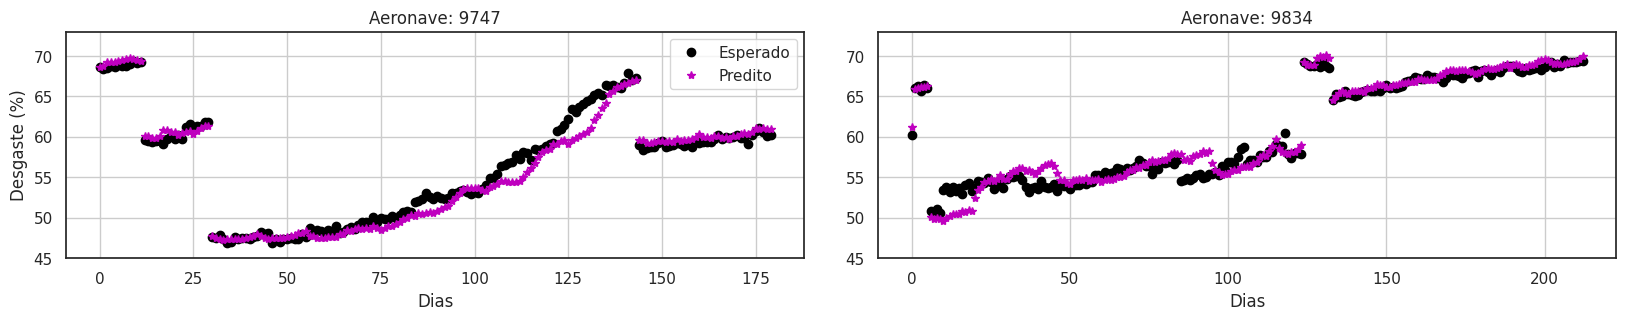

In [147]:
# plot_results(y_test,y_pred_rev,air_test=00)
# plt.vlines(discontinuity_filt(y_test), 0, 100)

indice= index_test(samples_test_best, look_back_best)

fig = plt.figure(figsize = (20,3),dpi=100)
axes = gridspec.GridSpec(nrows=1, ncols=2, figure=fig, wspace=0.1, hspace=0.2)
# im = ['a','b']
# i,s = 51,77 #Falha 1
i,s = 45,73 #Falha 23
# i,s = 64,74 #Falha 24
# i,s = -3,65#Falha 35

#plot do melhor modelo (9747)
ax = fig.add_subplot(axes[0])
ax.set_title("Aeronave: "+str(test[1]))
ax.grid()
# ax.text(-0.065, -0.17, im[0], size=20, weight='bold', transform=ax.transAxes)
ax.plot(y_test[0:indice],'ok')
ax.plot(y_pred_rev[0:indice],'*m')
# ax.set_ylim([-1,70])
ax.set_xlabel("Dias")
ax.set_ylabel("Desgaste (%)")
ax.legend(["Esperado",'Predito'])
ax.set_ylim(i,s)

#plot do melhor modelo (9834)
ax = fig.add_subplot(axes[1])
ax.set_title("Aeronave: "+str(test[0]))
ax.grid()
# ax.text(-0.065, -0.17, im[1], size=20, weight='bold', transform=ax.transAxes)
ax.plot(y_test[indice:-1],'ok')
ax.plot(y_pred_rev[indice:-1],'*m')
# ax.set_ylim([-1,70])
ax.set_xlabel("Dias")
# ax.set_ylabel("Desgaste (%)")
# ax.legend(["Esperado",'Predito'])
ax.set_ylim(i,s)

# plt.savefig('resultados/fig_results_predict_f'+str(fail)+'.pdf', format="pdf", dpi=1000, bbox_inches="tight")

## Plot do Modelo Ingênuo

In [ ]:
#Conferindo se o modelo ingênuo possui o mesmo valor do último dia de entrada
y = samples_test_best[:,19]
y_predito = samples_test_best[:,9]

print(y[0], y_predito[0])

#plot do modelo ingênuo (9747)
# plot_results(y[0:indice], y_predito[0:indice], test[1])
plot_results(y_predito[0:indice], y_pred_[0:indice], test[1])
#plot do modelo ingênuo (9834)
# plot_results(y[indice:], y_predito[indice:], test[0])

In [ ]:
#plot do modelo ingênuo (9747)
plot_results(y_test[0:indice], y_pred_[0:indice], test[1])
#plot do modelo ingênuo (9834)
plot_results(y_test[indice:], y_pred_[indice:], test[0])

In [ ]:
px.line(data_test, x='DT_PROC', y='VLR_DESG', color='COD_AENV', line_dash='COD_FALH')

# ARIMA


In [91]:
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


##ARIMA (1,1,0)

In [96]:
set_random_seed(123)

def train_arima(data, data_test):
  results = []
  indice_all = []
  all_test_list=[]
  all_pred_list=[]

  for fail in [1, 23, 24, 35]:
    for look_back in [10, 20, 30]:
      samples, samples_day = get_samples (data_test, fail, look_back)
      indice = index_test(samples, look_back)
      indice_all.append(indice)
      all_test =[]
      all_pred = []

      for i in range(0,samples.shape[0]):
        train=samples[:,0:look_back][i] #Entradas
        test=samples[:,look_back:look_back+10][i] #Saída utilizada

        model = ARIMA(train, order=(1, 1, 0))  #Parâmetros anteriores(1,1,0)
        model_fit = model.fit()
        forecast = model_fit.predict(start = look_back, end = look_back, type='levels')
        

        all_test.append(test[-1])
        all_pred.append(forecast[0])
      
      # indice = index_test(all_test, look_back)
      result = metrics_test(all_test, all_pred, indice)
      result.append(look_back)
      result.append(fail)
      results.append(result)

      all_test_list.append(all_test)
      all_pred_list.append(all_pred)

  #cria o dataframe com os resultados
  data_results = pd.DataFrame(results, columns= ['RMSE Médio', 'RMSE', 'MSE', 'MaxE', 'MAE', "R2", 'Janela', 'Falha'])

  return data_results, all_test_list, all_pred_list, indice_all

data_results, all_test_list, all_pred_list, indice_all = train_arima(data, data_test)



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive paramete

In [ ]:
all_pred_list[1]

In [98]:
pd.set_option('display.max_colwidth', True)
data_results.head(12)

,RMSE Médio,RMSE,MSE,MaxE,MAE,R2,Janela,Falha
0,1.205,"[1.078, 1.332]","[1.161, 1.774]","[4.268, 4.606]","[0.895, 1.092]","[0.907, 0.959]",10,1
1,1.176,"[1.12, 1.231]","[1.255, 1.516]","[3.053, 4.27]","[0.936, 1.071]","[0.921, 0.953]",20,1
2,1.088,"[1.057, 1.12]","[1.116, 1.254]","[1.961, 4.274]","[0.937, 0.968]","[0.94, 0.947]",30,1
3,1.450,"[1.283, 1.616]","[1.647, 2.611]","[4.287, 5.732]","[1.039, 1.122]","[0.943, 0.963]",10,23
4,1.462,"[1.231, 1.694]","[1.514, 2.868]","[4.198, 5.47]","[0.973, 1.18]","[0.937, 0.964]",20,23
5,1.558,"[1.235, 1.882]","[1.525, 3.542]","[4.198, 5.465]","[0.954, 1.367]","[0.92, 0.961]",30,23
6,1.653,"[1.128, 2.178]","[1.273, 4.742]","[3.498, 10.265]","[0.919, 1.477]","[0.456, 0.695]",10,24
7,1.094,"[1.076, 1.112]","[1.159, 1.237]","[3.337, 3.552]","[0.859, 0.876]","[0.444, 0.632]",20,24
8,0.893,"[0.785, 1.0]","[0.616, 1.0]","[1.879, 3.205]","[0.673, 0.753]","[0.604, 0.646]",30,24
9,3.434,"[2.13, 4.739]","[4.538, 22.454]","[6.526, 30.348]","[1.598, 2.385]","[0.772, 0.847]",10,35


In [99]:
print(data_results.drop("MSE", axis=1).to_latex(index=False))

\begin{tabular}{rllllrr}
\toprule
 RMSE Médio &           RMSE &            MaxE &            MAE &             R2 &  Janela &  Falha \\
\midrule
1.205 & [1.078, 1.332] & [4.268, 4.606] & [0.895, 1.092] & [0.907, 0.959] & 10 & 1 \\
1.176 & [1.12, 1.231] & [3.053, 4.27] & [0.936, 1.071] & [0.921, 0.953] & 20 & 1 \\
1.088 & [1.057, 1.12] & [1.961, 4.274] & [0.937, 0.968] & [0.94, 0.947] & 30 & 1 \\
1.450 & [1.283, 1.616] & [4.287, 5.732] & [1.039, 1.122] & [0.943, 0.963] & 10 & 23 \\
1.462 & [1.231, 1.694] & [4.198, 5.47] & [0.973, 1.18] & [0.937, 0.964] & 20 & 23 \\
1.558 & [1.235, 1.882] & [4.198, 5.465] & [0.954, 1.367] & [0.92, 0.961] & 30 & 23 \\
1.653 & [1.128, 2.178] & [3.498, 10.265] & [0.919, 1.477] & [0.456, 0.695] & 10 & 24 \\
1.094 & [1.076, 1.112] & [3.337, 3.552] & [0.859, 0.876] & [0.444, 0.632] & 20 & 24 \\
0.893 & [0.785, 1.0] & [1.879, 3.205] & [0.673, 0.753] & [0.604, 0.646] & 30 & 24 \\
3.434 & [2.13, 4.739] & [6.526, 30.348] & [1.598, 2.385] & [0.772, 0.847] & 10 & 3

###Plot do ARIMA

In [ ]:
count = 0
for fail in [1, 23, 24, 35]:
  for look_back in [10, 20, 30]:
    fig = plt.figure(figsize = (20,10),dpi=100)
    axes = gridspec.GridSpec(nrows=2, ncols=1, figure=fig, wspace=0.2, hspace=0.3)
    im = ['a','b']
    indice=indice_all[count]
    all_test = all_test_list[count]
    all_pred = all_pred_list[count]
    count+=1


    #plot do melhor modelo (9747)
    ax = fig.add_subplot(axes[0])
    ax.set_title("FALHA:"+str(fail)+" LK:"+str(look_back)+" RMSE:"+ str(round(rmse(all_test[0:indice],all_pred[0:indice]),3)))
    ax.grid()
    ax.text(-0.05, -0.1, im[0], size=20, weight='bold', transform=ax.transAxes)
    ax.plot(all_test[0:indice],':ok')
    ax.plot(all_pred[0:indice],'-xm')
    # ax.set_ylim([-1,70])
    ax.set_xlabel("Dias")
    ax.set_ylabel("Desgaste")
    ax.legend(["Esperado",'Predito'])

    #plot do melhor modelo (9834)
    ax = fig.add_subplot(axes[1])
    ax.set_title("FALHA:"+str(fail)+" LK:"+str(look_back)+" RMSE:"+ str(round(rmse(all_test[indice:-1],all_pred[indice:-1]),3)))
    ax.grid()
    ax.text(-0.05, -0.1, im[1], size=20, weight='bold', transform=ax.transAxes)
    ax.plot(all_test[indice:-1],':ok')
    ax.plot(all_pred[indice:-1],'-xm')
    # ax.set_ylim([-1,70])
    ax.set_xlabel("Dias")
    ax.set_ylabel("Desgaste")
    ax.legend(["Esperado",'Predito'])

    print(round(rmse(all_test[0:-1],all_pred[0:-1]),3))
# plt.savefig('resultados/fig_results_predict_f'+str(cod_falha)+'.pdf', format="pdf", dpi=1000, bbox_inches="tight")

##ARIMA COM AUTOREGRESSÃO

  * Só prevê o próximo dia, mas usa essa informação para ir prevendo o 10



In [ ]:
# train, test = X[0:size], X[size:len(X)]

all_test =[]
all_pred = []


for i in range(0,samples.shape[0]):
  train=samples[:,0:look_back][i] #Entradas
  test=samples[:,look_back:look_back+10][i] #Saída utilizada
  history = [x for x in train]
  predictions = list()
  # walk-forward validation
  for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = yhat
    history.append(obs)
    #
    # print('predicted=%f, expected=%f' % (yhat, obs))

    # evaluate forecasts
    # rmse = sqrt(mean_squared_error(test, predictions))
    # print('Test RMSE: %.3f' % rmse)
    # plot forecasts against actual outcomes

  all_test.append(test[-1])
  all_pred.append(predictions[-1])
  
# output[0]

###Plot do ARIMA

In [ ]:
fig = plt.figure(figsize = (20,10),dpi=100)
axes = gridspec.GridSpec(nrows=2, ncols=1, figure=fig, wspace=0.2, hspace=0.3)
im = ['a','b']

np.diff(samples[:,look_back+10])

count = 0
for i in np.diff(samples[:,look_back+10]):
  # print (i)
  if i !=0:
    indice = count
  count = count+1


#plot do melhor modelo (9747)
ax = fig.add_subplot(axes[0])
ax.set_title("RMSE:"+ str(round(rmse(all_test[0:indice],all_pred[0:indice]),3)))
ax.grid()
ax.text(-0.05, -0.1, im[0], size=20, weight='bold', transform=ax.transAxes)
ax.plot(all_test[0:indice],':ok')
ax.plot(all_pred[0:indice],'-xm')
ax.set_ylim([-1,70])
ax.set_xlabel("Dias")
ax.set_ylabel("Desgaste")
ax.legend(["Esperado",'Predito'])

#plot do melhor modelo (9834)
ax = fig.add_subplot(axes[1])
ax.set_title("RMSE:"+ str(round(rmse(all_test[indice:-1],all_pred[indice:-1]),3)))
ax.grid()
ax.text(-0.05, -0.1, im[1], size=20, weight='bold', transform=ax.transAxes)
ax.plot(all_test[indice:-1],':ok')
ax.plot(all_pred[indice:-1],'-xm')
ax.set_ylim([-1,70])
ax.set_xlabel("Dias")
ax.set_ylabel("Desgaste")
ax.legend(["Esperado",'Predito'])

print(round(rmse(all_test[0:-1],all_pred[0:-1]),3))


# plt.savefig('resultados/fig_results_predict_f'+str(cod_falha)+'.pdf', format="pdf", dpi=1000, bbox_inches="tight")